In [7]:
import numpy as np
import tensorflow as tf
import keras
from keras import layers

In [8]:
# this sampling layer is the bottleneck layer of variational autoencoder,
# it uses the output from two dense layers z_mean and z_log_var as input, 
# convert them into normal distribution and pass them to the decoder layer

class Sampling(layers.Layer):
	"""Uses (mean, log_var) to sample z, the vector encoding a digit."""

	def call(self, inputs):
		mean, log_var = inputs
		batch = tf.shape(mean)[0]
		dim = tf.shape(mean)[1]
		epsilon = tf.random.normal(shape=(batch, dim))
		return mean + tf.exp(0.5 * log_var) * epsilon


This code defines a custom Keras layer called `Sampling`, which is designed to operate within a variational autoencoder (VAE) architecture. In a VAE, there is a bottleneck layer where the input data is transformed into a latent space representation. This layer is where the model learns a probabilistic distribution of the input data.

Here's a breakdown of what each part does:

- `class Sampling(layers.Layer):`: This line defines a custom Keras layer named `Sampling`. Custom layers are subclasses of `tf.keras.layers.Layer` in TensorFlow.

- `def call(self, inputs):`: This method overrides the `call` method of the base `Layer` class. It defines the computation that the layer performs when called with some input.

- `mean, log_var = inputs`: In a VAE, the encoder typically produces two outputs: the mean and the log of the variance of the latent variables. These are the parameters of a Gaussian distribution that the encoder believes the latent variables should follow.

- `batch = tf.shape(mean)[0]` and `dim = tf.shape(mean)[1]`: These lines calculate the batch size and the dimensionality of the latent space.

- `epsilon = tf.random.normal(shape=(batch, dim))`: Here, a random sample (epsilon) is drawn from a standard normal distribution with the same shape as the mean and log variance.

- `return mean + tf.exp(0.5 * log_var) * epsilon`: This line implements the reparameterization trick. Instead of directly sampling from the learned distribution, which would make backpropagation through the stochastic process impossible, the trick involves introducing a small amount of noise sampled from a fixed distribution (in this case, a standard normal distribution) and then transforming it according to the learned distribution parameters (mean and log variance) to obtain the latent variable. This enables gradient-based optimization to work effectively during training.

In summary, this `Sampling` layer takes the mean and log variance vectors produced by the encoder and generates a sample from the corresponding learned distribution using the reparameterization trick. This sample is then passed to the decoder to reconstruct the input data.

In [9]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(128, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
mean = layers.Dense(latent_dim, name="mean")(x)
log_var = layers.Dense(latent_dim, name="log_var")(x)
z = Sampling()([mean, log_var])
encoder = keras.Model(encoder_inputs, [mean, log_var, z], name="encoder")
encoder.summary()


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d_12 (Conv2D)          (None, 14, 14, 64)           640       ['input_1[0][0]']             
                                                                                                  
 conv2d_13 (Conv2D)          (None, 7, 7, 128)            73856     ['conv2d_12[0][0]']           
                                                                                                  
 flatten_6 (Flatten)         (None, 6272)                 0         ['conv2d_13[0][0]']           
                                                                                            

This code defines the encoder part of a variational autoencoder (VAE) using Keras. Here's a breakdown of the code:

Here's what each part does:

- `latent_dim = 2`: Specifies the dimensionality of the latent space. In this case, it's set to 2, meaning the latent space will be two-dimensional.
- `encoder_inputs = keras.Input(shape=(28, 28, 1))`: Defines the input layer for the encoder. It expects input images with shape (28, 28, 1), where 1 represents a single channel (grayscale).
- Convolutional layers: Two convolutional layers are used to extract features from the input images while downsampling the spatial dimensions. Each convolutional layer is followed by ReLU activation and uses a kernel size of 3x3.
- `layers.Flatten()(x)`: Flattens the output from the convolutional layers to prepare it for feeding into the dense layers.
- `layers.Dense(16, activation="relu")(x)`: A dense layer with ReLU activation is added to further process the flattened output.
- `mean = layers.Dense(latent_dim, name="mean")(x)` and `log_var = layers.Dense(latent_dim, name="log_var")(x)`: Two separate dense layers are added to output the mean and log variance vectors, respectively, for the latent space.
- `z = Sampling()([mean, log_var])`: Applies the custom `Sampling` layer defined earlier to sample from the latent space based on the mean and log variance vectors.
- `encoder = keras.Model(encoder_inputs, [mean, log_var, z], name="encoder")`: Defines the encoder model with the input layer `encoder_inputs` and outputs `[mean, log_var, z]`.
- `encoder.summary()`: Prints a summary of the encoder model, showing the architecture and the number of parameters.

Overall, this code sets up an encoder model for a VAE, which takes input images, encodes them into a lower-dimensional latent space, and outputs the mean, log variance, and a sampled latent vector.

In [10]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(128, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()


Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_19 (Dense)            (None, 3136)              9408      
                                                                 
 reshape_6 (Reshape)         (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose_12 (Conv2  (None, 14, 14, 128)       73856     
 DTranspose)                                                     
                                                                 
 conv2d_transpose_13 (Conv2  (None, 28, 28, 64)        73792     
 DTranspose)                                                     
                                                                 
 conv2d_transpose_14 (Conv2  (None, 28, 28, 1)         577 

In decoder architecture, we are reshaping the input from a flattened vector to a shape compatible with convolutional layers. Let's break it down:

1. You start with a dense layer that outputs a vector with a shape of `(7 * 7 * 64)`.
2. You reshape this vector into a shape `(7, 7, 64)`, which is compatible with a convolutional layer.

The reason you use `7 * 7 * 64` in the dense layer is because of the downsampling operations in the encoder. Your encoder consists of convolutional layers with strides of 2, which effectively reduces the spatial dimensions of the input by half each time.

So, starting with a `(28, 28, 1)` input, after two convolutional layers with strides of 2, the spatial dimensions become `(7, 7, 128)`. Then, you flatten this to pass through a dense layer. Since you want to reverse this process in the decoder, you need to make sure the dense layer outputs a shape compatible with reshaping back to `(7, 7, 64)`.

Therefore, you calculate the output shape of the last convolutional layer in the encoder, which is `(7, 7, 128)`. The number of channels (depth) is `128`, so when you reshape it, you maintain the spatial dimensions `(7, 7)` and the same number of channels `128`. Hence, the input shape for the dense layer in the decoder should be `7 * 7 * 128`. 

However, in your decoder, you seem to have halved the number of channels in the transposed convolutional layers. So, you've used `64` instead of `128`. This is fine as long as it corresponds to the structure of your encoder. You might have chosen to reduce the number of channels to simplify the architecture or because it suits your specific problem domain.

This code defines the decoder part of the variational autoencoder (VAE) using Keras. Let's break it down:

```python
latent_inputs = keras.Input(shape=(latent_dim,))
```
Defines the input layer for the decoder, which expects input vectors of shape `(latent_dim,)`, where `latent_dim` is the dimensionality of the latent space.

```python
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
```
Applies a dense layer to the input, mapping it to a higher-dimensional space suitable for convolutional operations. The output shape will be `(7 * 7 * 64,)`.

```python
x = layers.Reshape((7, 7, 64))(x)
```
Reshapes the output from the dense layer into a 3D tensor with shape `(7, 7, 64)`. This prepares it for the subsequent convolutional transpose layers, effectively "unflattening" it.

```python
x = layers.Conv2DTranspose(128, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
```
Two convolutional transpose layers are used to upsample the tensor. Convolutional transpose layers (also known as deconvolutional layers) reverse the process of convolution by increasing the spatial dimensions of the input tensor.

```python
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
```
The final convolutional transpose layer produces the decoder outputs. It generates a single-channel output (since the input images are grayscale) using a sigmoid activation function to ensure the output pixel values are in the range [0, 1].

```python
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
```
Defines the decoder model with the input layer `latent_inputs` and output layer `decoder_outputs`.

```python
decoder.summary()
```
Prints a summary of the decoder model, showing the architecture and the number of parameters.

Overall, this decoder architecture takes a latent vector as input and transforms it into an output image through a series of deconvolutional operations, aiming to reconstruct the input image from its lower-dimensional latent representation.

In [11]:
class VAE(keras.Model):
	def __init__(self, encoder, decoder, **kwargs):
		super().__init__(**kwargs)
		self.encoder = encoder
		self.decoder = decoder
		self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
		self.reconstruction_loss_tracker = keras.metrics.Mean(
			name="reconstruction_loss"
		)
		self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

	@property
	def metrics(self):
		return [
			self.total_loss_tracker,
			self.reconstruction_loss_tracker,
			self.kl_loss_tracker,
		]

	def train_step(self, data):
		with tf.GradientTape() as tape:
			mean,log_var, z = self.encoder(data)
			reconstruction = self.decoder(z)
			reconstruction_loss = tf.reduce_mean(
				tf.reduce_sum(
					keras.losses.binary_crossentropy(data, reconstruction),
					axis=(1, 2),
				)
			)
			kl_loss = -0.5 * (1 + log_var - tf.square(mean) - tf.exp(log_var))
			kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
			total_loss = reconstruction_loss + kl_loss
		grads = tape.gradient(total_loss, self.trainable_weights)
		self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
		self.total_loss_tracker.update_state(total_loss)
		self.reconstruction_loss_tracker.update_state(reconstruction_loss)
		self.kl_loss_tracker.update_state(kl_loss)
		return {
			"loss": self.total_loss_tracker.result(),
			"reconstruction_loss": self.reconstruction_loss_tracker.result(),
			"kl_loss": self.kl_loss_tracker.result(),
		}


let's break down the `train_step` method step by step:

```python
def train_step(self, data):
```
This method defines a single training step for the VAE model. It takes a batch of data (`data`) as input.

```python
with tf.GradientTape() as tape:
```
This context manager records operations for automatic differentiation. It watches all the trainable variables accessed within its scope.

```python
mean, log_var, z = self.encoder(data)
```
The encoder takes the input data and produces the mean (`mean`) and log variance (`log_var`) of the latent space, as well as the sampled latent vector (`z`) using the reparameterization trick.

```python
reconstruction = self.decoder(z)
```
The decoder takes the sampled latent vector `z` and reconstructs the input data.

```python
reconstruction_loss = tf.reduce_mean(
    tf.reduce_sum(
        keras.losses.binary_crossentropy(data, reconstruction),
        axis=(1, 2),
    )
)
```
This calculates the reconstruction loss using binary cross-entropy. It measures the difference between the input data (`data`) and the reconstructed data (`reconstruction`). The reduction is done both across the width and height of the image (`axis=(1, 2)`) and then averaged over the batch.

```python
kl_loss = -0.5 * (1 + log_var - tf.square(mean) - tf.exp(log_var))
kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
```
This calculates the Kullback-Leibler (KL) divergence loss, which measures the difference between the learned latent distribution and the prior distribution (usually a standard normal distribution). It's computed based on the mean and log variance vectors produced by the encoder.

```python
total_loss = reconstruction_loss + kl_loss
```
The total loss is the sum of the reconstruction loss and the KL divergence loss. This is the final loss function that the model aims to minimize during training.

```python
grads = tape.gradient(total_loss, self.trainable_weights)
```
This computes the gradients of the total loss with respect to the trainable weights of the model using automatic differentiation.

```python
self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
```
The gradients are applied to the model's trainable weights using the optimizer.

```python
self.total_loss_tracker.update_state(total_loss)
self.reconstruction_loss_tracker.update_state(reconstruction_loss)
self.kl_loss_tracker.update_state(kl_loss)
```
The custom loss trackers update their states with the current values of the total loss, reconstruction loss, and KL divergence loss.

```python
return {
    "loss": self.total_loss_tracker.result(),
    "reconstruction_loss": self.reconstruction_loss_tracker.result(),
    "kl_loss": self.kl_loss_tracker.result(),
}
```
This method returns a dictionary containing the loss values from the custom loss trackers. This allows you to monitor the training progress and evaluate the performance of the model during training.

In [13]:
(x_train, _), (x_test, _) = keras.datasets.fashion_mnist.load_data() # load mnist digit data
fashion_mnist = np.concatenate([x_train, x_test], axis=0)
fashion_mnist = np.expand_dims(fashion_mnist, -1).astype("float32") / 255

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
history = vae.fit(fashion_mnist, epochs=5, batch_size=128)

Epoch 1/5
547/547 [==============================] - 327s 594ms/step - loss: 312.2819 - reconstruction_loss: 284.9284 - kl_loss: 6.8924
Epoch 2/5
547/547 [==============================] - 298s 545ms/step - loss: 274.4474 - reconstruction_loss: 267.2747 - kl_loss: 6.0782
Epoch 3/5
547/547 [==============================] - 351s 642ms/step - loss: 270.2588 - reconstruction_loss: 264.0251 - kl_loss: 6.0317
Epoch 4/5
547/547 [==============================] - 217s 396ms/step - loss: 268.5513 - reconstruction_loss: 262.2565 - kl_loss: 6.0588
Epoch 5/5
547/547 [==============================] - 112s 205ms/step - loss: 267.4327 - reconstruction_loss: 261.2069 - kl_loss: 6.0683


This code loads the Fashion MNIST dataset, preprocesses it, and trains the VAE model using the defined architecture. Let's go through it step by step:

```python
(x_train, _), (x_test, _) = keras.datasets.fashion_mnist.load_data()
```
This line loads the Fashion MNIST dataset using Keras. The dataset consists of 28x28 grayscale images of clothing items, divided into training and test sets.

```python
fashion_mnist = np.concatenate([x_train, x_test], axis=0)
```
It concatenates the training and test sets along the first axis (axis 0) to create a single dataset containing all the images.

```python
fashion_mnist = np.expand_dims(fashion_mnist, -1).astype("float32") / 255
```
This line preprocesses the dataset. It first expands the dimensions of the dataset by adding a new axis at the end (-1) to represent the single channel (grayscale). Then, it converts the datatype to float32 and normalizes the pixel values to the range [0, 1] by dividing by 255.

```python
vae = VAE(encoder, decoder)
```
An instance of the VAE model is created by passing the previously defined encoder and decoder models to the `VAE` class constructor.

```python
vae.compile(optimizer=keras.optimizers.Adam())
```
The model is compiled with the Adam optimizer. Since the VAE class defines its custom training loop, the loss function and metrics are handled internally within the `train_step` method.

```python
history = vae.fit(fashion_mnist, epochs=5, batch_size=128)
```
The model is trained on the preprocessed Fashion MNIST dataset for 5 epochs with a batch size of 128. During training, the `fit` method iterates over the dataset, performing forward and backward passes, and updating the model's weights based on the calculated gradients.

The training history, containing information about the loss values at each epoch, is stored in the `history` variable. This information can be used for visualization and analysis.

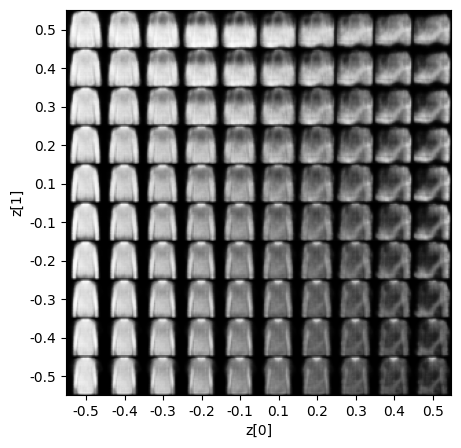

In [14]:
import matplotlib.pyplot as plt

def plot_latent_space(vae, n=10, figsize=5):
	# display a n*n 2D manifold of images
	img_size = 28
	scale = 0.5
	figure = np.zeros((img_size * n, img_size * n))
	# linearly spaced coordinates corresponding to the 2D plot
	# of images classes in the latent space
	grid_x = np.linspace(-scale, scale, n)
	grid_y = np.linspace(-scale, scale, n)[::-1]

	for i, yi in enumerate(grid_y):
		for j, xi in enumerate(grid_x):
			sample = np.array([[xi, yi]])
			x_decoded = vae.decoder.predict(sample, verbose=0)
			images = x_decoded[0].reshape(img_size, img_size)
			figure[
				i * img_size : (i + 1) * img_size,
				j * img_size : (j + 1) * img_size,
			] = images

	plt.figure(figsize=(figsize, figsize))
	start_range = img_size // 2
	end_range = n * img_size + start_range
	pixel_range = np.arange(start_range, end_range, img_size)
	sample_range_x = np.round(grid_x, 1)
	sample_range_y = np.round(grid_y, 1)
	plt.xticks(pixel_range, sample_range_x)
	plt.yticks(pixel_range, sample_range_y)
	plt.xlabel("z[0]")
	plt.ylabel("z[1]")
	plt.imshow(figure, cmap="Greys_r")
	plt.show()


plot_latent_space(vae)


This function, `plot_latent_space`, visualizes the latent space learned by the VAE model by generating images based on samples from the latent space.

Here's how it works:

1. **Input Parameters**: 
   - `vae`: The trained VAE model.
   - `n`: The number of images to display along each axis in the grid (default is 10).
   - `figsize`: The size of the figure (default is 5).

2. **Initialize Variables**:
   - `img_size`: The size of the images (assumed square).
   - `scale`: The range of values for the latent space. Images will be generated within the range (-scale, scale).
   - `figure`: An array to store the generated images.

3. **Generate Grid in Latent Space**:
   - `grid_x` and `grid_y`: Linearly spaced coordinates corresponding to the 2D plot of image classes in the latent space.
   
4. **Generate Images**:
   - Loop through each coordinate in the grid and:
     - Create a sample point in the latent space using the current coordinates.
     - Use the decoder part of the VAE to generate an image based on this sample.
     - Reshape the generated image to the original image size.
     - Place the generated image in the appropriate position in the `figure` array.

5. **Plotting**:
   - Create a figure with the specified size.
   - Set tick marks and labels based on the sample ranges in the latent space.
   - Plot the `figure` array as an image using grayscale colormap.

6. **Display**:
   - Show the plot.

This function generates a grid of images where each row represents a different value of one of the latent dimensions (`z[1]`), and each column represents a different value of the other latent dimension (`z[0]`). The generated images visualize how the VAE interprets different regions of the latent space and what kinds of images it can generate from those regions.

1875/1875 [==============================] - 17s 9ms/step


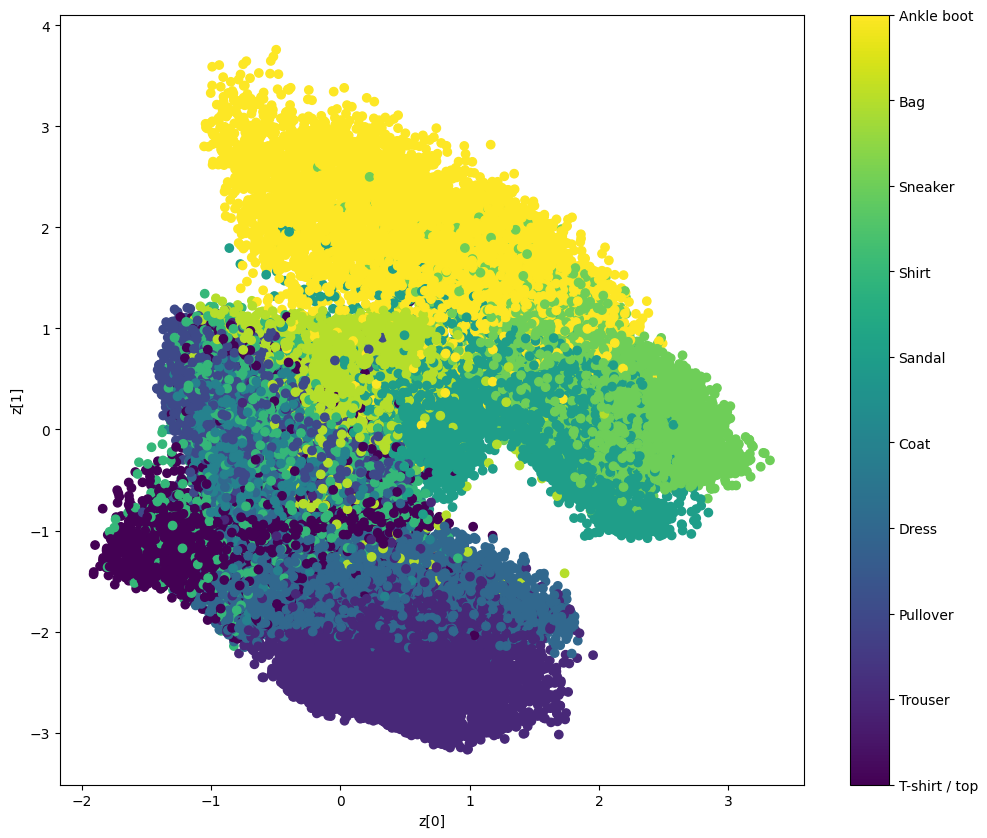

In [15]:
def plot_label_clusters(encoder, decoder, data, test_lab):
	z_mean, _, _ = encoder.predict(data)
	plt.figure(figsize =(12, 10))
	sc = plt.scatter(z_mean[:, 0], z_mean[:, 1], c = test_lab)
	cbar = plt.colorbar(sc, ticks = range(10))
	cbar.ax.set_yticklabels([labels.get(i) for i in range(10)])
	plt.xlabel("z[0]")
	plt.ylabel("z[1]")
	plt.show()


labels = {0 :"T-shirt / top",
1: "Trouser",
2: "Pullover",
3: "Dress",
4: "Coat",
5: "Sandal",
6: "Shirt",
7: "Sneaker",
8: "Bag",
9: "Ankle boot"}

(x_train, y_train), _ = keras.datasets.fashion_mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255
plot_label_clusters(encoder, decoder, x_train, y_train)

This `plot_label_clusters` function visualizes the clusters of encoded data points in the latent space, colored according to their corresponding labels. Here's a step-by-step explanation:

```python
def plot_label_clusters(encoder, decoder, data, test_lab):
```
This function takes four arguments:
- `encoder`: The encoder model.
- `decoder`: The decoder model.
- `data`: The input data.
- `test_lab`: The labels corresponding to the input data.

```python
z_mean, _, _ = encoder.predict(data)
```
The encoder model predicts the mean of the latent space representation (`z_mean`) for the given input data.

```python
plt.figure(figsize =(12, 10))
```
Creates a new figure for the plot with a specified size.

```python
sc = plt.scatter(z_mean[:, 0], z_mean[:, 1], c = test_lab)
```
Plots the data points in the latent space (`z_mean`) on a scatter plot. The color of each point is determined by its corresponding label (`test_lab`).

```python
cbar = plt.colorbar(sc, ticks = range(10))
cbar.ax.set_yticklabels([labels.get(i) for i in range(10)])
```
Adds a colorbar to the plot, with ticks corresponding to the labels 0 through 9. The labels are set according to the dictionary `labels`.

```python
plt.xlabel("z[0]")
plt.ylabel("z[1]")
```
Labels the x-axis and y-axis of the plot as "z[0]" and "z[1]" respectively.

```python
plt.show()
```
Displays the plot.

This function allows you to visualize how different classes of data points are distributed in the latent space. Each point represents an encoded version of an input image, and its color indicates the class label of the corresponding image.